In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 33.0 MB/s eta 0:00:00


# Generar caracteres con 2 qubits

Codificar un alfabeto muy pequeño en qubits.
Definir un circuito cuántico parametrizado capaz de generar una distribución sobre esos caracteres (vía medición).
Entrenar el circuito para que dicha distribución se acerque a la de un dataset objetivo (en este caso, lo haremos de forma muy sencilla).

In [ ]:
  import pennylane as qml
  from pennylane import numpy as np

  # -----------------------------------------------------------------------------
  # 1. Configuración del dispositivo
  # -----------------------------------------------------------------------------
  # Usamos 2 qubits en modo analítico (sin shots finitos)
  dev = qml.device("default.qubit", wires=2, shots=None)

  # -----------------------------------------------------------------------------
  # 2. Definición del alfabeto y distribución objetivo
  # -----------------------------------------------------------------------------
  bitstring_to_char = {"00": "A", "01": "B", "10": "C", "11": "_"}
  target_probs = np.array([0.4, 0.3, 0.2, 0.1])

  # -----------------------------------------------------------------------------
  # 3. Definición del circuito generador
  # -----------------------------------------------------------------------------
  # Arquitectura:
  # - Primera capa de rotaciones: 4 parámetros (rotaciones RY y RZ en cada qubit)
  # - Primera capa de entrelazamiento: CNOT entre qubits 0 y 1
  # - Segunda capa de rotaciones: 2 parámetros (rotaciones RY en cada qubit)
  # - Segunda capa de entrelazamiento: otro CNOT
  # - Tercera capa de rotaciones: 2 parámetros (rotaciones RY en cada qubit)
  #
  # Esto da un total de 8 parámetros.
  @qml.qnode(dev)
  def generative_circuit(params):
      # Primera capa de rotaciones (4 parámetros)
      qml.RY(params[0], wires=0)
      qml.RZ(params[1], wires=0)
      qml.RY(params[2], wires=1)
      qml.RZ(params[3], wires=1)

      # Primera capa de entrelazamiento
      qml.CNOT(wires=[0, 1])

      # Segunda capa de rotaciones (2 parámetros)
      qml.RY(params[4], wires=0)
      qml.RY(params[5], wires=1)

      # Segunda capa de entrelazamiento
      qml.CNOT(wires=[0, 1])

      # Tercera capa de rotaciones (2 parámetros)
      qml.RY(params[6], wires=0)
      qml.RY(params[7], wires=1)

      # Devolvemos la distribución exacta sobre los 4 estados
      return qml.probs(wires=[0, 1])

  # -----------------------------------------------------------------------------
  # 4. Función de costo (MSE)
  # -----------------------------------------------------------------------------
  def cost(params):
      dist = generative_circuit(params)
      return np.mean((dist - target_probs)**2)

  # -----------------------------------------------------------------------------
  # 5. Proceso de entrenamiento con Adam
  # -----------------------------------------------------------------------------
  # Usamos AdamOptimizer con una tasa de aprendizaje menor.
  opt = qml.AdamOptimizer(stepsize=0.05)

  # Inicializamos 8 parámetros aleatorios
  np.random.seed(42)
  params = 0.01 * np.random.randn(8)

  # Entrenamos
  num_epochs = 130 #Cuanto mayo es el número de epoch, más se acerca a la distribución real
  for epoch in range(num_epochs):
      params, current_cost = opt.step_and_cost(cost, params)
      if epoch % 20 == 0:
          print(f"Epoch {epoch:3d}: Cost = {current_cost:.6f}")

  # -----------------------------------------------------------------------------
  # 6. Evaluación final: mostramos la distribución generada
  # -----------------------------------------------------------------------------
  final_probs = generative_circuit(params)
  print("\nDistribución generada final:")
  for bitstring, prob in zip(["00", "01", "10", "11"], final_probs):
      print(f"Estado {bitstring} ({bitstring_to_char[bitstring]}): {prob:.3f}")


Epoch   0: Cost = 0.124941
Epoch  20: Cost = 0.006731
Epoch  40: Cost = 0.001174
Epoch  60: Cost = 0.000102
Epoch  80: Cost = 0.000009
Epoch 100: Cost = 0.000001
Epoch 120: Cost = 0.000000

Distribución generada final:
Estado 00 (A): 0.400
Estado 01 (B): 0.300
Estado 10 (C): 0.200
Estado 11 (_): 0.100


(<Figure size 900x300 with 1 Axes>, <Axes: >)

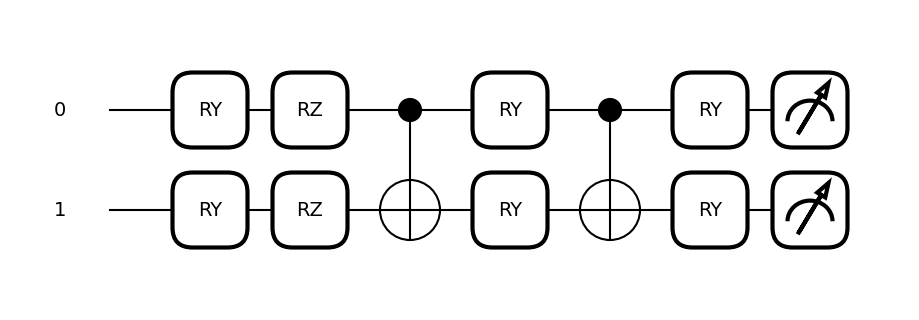

In [ ]:
qml.draw_mpl(generative_circuit)(params)

# Generar secuencias de 2 caracteres con 4 qubits.



*   "00" se mapea a A
*   "01" se mapea a B
*   "10" se mapea a C
*   "11" se mapea a _

La secuencia se obtiene dividiendo la cadena de 4 bits en dos grupos de 2 bits. Por ejemplo, el estado "0101" se convierte en la secuencia "B" + "B" = "BB".



In [ ]:
import pennylane as qml
from pennylane import numpy as np

# -----------------------------------------------------------------------------
# 1. Configuración del dispositivo para 4 qubits (secuencias de 2 caracteres)
# -----------------------------------------------------------------------------
# Usamos un dispositivo analítico para obtener probabilidades exactas (shots=None)
dev_seq = qml.device("default.qubit", wires=4, shots=None)

# -----------------------------------------------------------------------------
# 2. Definición del circuito cuántico para generar secuencias
# -----------------------------------------------------------------------------
# Este circuito utiliza dos bloques de operaciones:
#   - Primer bloque: para cada uno de los 4 qubits, aplicamos RY y RZ (8 parámetros)
#   - Entrelazamiento: aplicamos una cadena de puertas CNOT (0→1, 1→2, 2→3)
#   - Segundo bloque: para cada qubit, aplicamos una rotación RY (4 parámetros)
# El total de parámetros es 12.
@qml.qnode(dev_seq)
def sequence_circuit(params):
    # Primer bloque: rotaciones en cada qubit (8 parámetros)
    for i in range(4):
        qml.RY(params[2*i], wires=i)
        qml.RZ(params[2*i + 1], wires=i)

    # Capa de entrelazamiento: conectamos los qubits en cadena
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])

    # Segundo bloque: una rotación RY en cada qubit (4 parámetros)
    for i in range(4):
        qml.RY(params[8 + i], wires=i)

    # Medimos en la base computacional: se devuelve un vector de 16 probabilidades
    return qml.probs(wires=[0, 1, 2, 3])

# -----------------------------------------------------------------------------
# 3. Mapeo de estados a secuencias de 2 caracteres
# -----------------------------------------------------------------------------
# Definimos la asignación para 2 bits:
bit_mapping = {"00": "A", "01": "B", "10": "C", "11": "_"}

def bitstring_to_sequence(bitstring):
    """
    Convierte una cadena de 4 bits en una secuencia de 2 caracteres.
    Se toman los dos primeros bits para el primer carácter y los dos últimos para el segundo.
    """
    return bit_mapping[bitstring[:2]] + bit_mapping[bitstring[2:]]

def all_bitstrings(n):
    """Genera una lista con todas las cadenas binarias de longitud n en orden lexicográfico."""
    if n == 0:
        return [""]
    else:
        smaller = all_bitstrings(n-1)
        return [s + "0" for s in smaller] + [s + "1" for s in smaller]

# Lista de todos los estados (4-bit strings) en orden lexicográfico:
bitstrings = all_bitstrings(4)

# -----------------------------------------------------------------------------
# 4. Definición de la distribución objetivo para las secuencias
# -----------------------------------------------------------------------------
# Se define un diccionario donde se asigna una probabilidad a cada secuencia de 2 caracteres.
target_seq_probs = {
    "AA": 0.10,
    "AB": 0.20,
    "AC": 0.05,
    "A_": 0.05,
    "BA": 0.10,
    "BB": 0.05,
    "BC": 0.05,
    "B_": 0.05,
    "CA": 0.05,
    "CB": 0.05,
    "CC": 0.05,
    "C_": 0.05,
    "_A": 0.05,
    "_B": 0.05,
    "_C": 0.05,
    "__": 0.05
}

# Creamos un vector (array) de 16 elementos con la probabilidad objetivo para cada estado,
# usando el mapeo de cada bitstring a secuencia.
target_distribution = np.array([target_seq_probs[bitstring_to_sequence(bs)] for bs in bitstrings])

# -----------------------------------------------------------------------------
# 5. Definición de la función de costo
# -----------------------------------------------------------------------------
# Se utiliza el error cuadrático medio (MSE) entre la distribución generada por el circuito
# y la distribución objetivo.
def cost_seq(params):
    output_probs = sequence_circuit(params)  # Vector de 16 probabilidades
    return np.mean((output_probs - target_distribution)**2)

# -----------------------------------------------------------------------------
# 6. Proceso de entrenamiento
# -----------------------------------------------------------------------------
# Se utiliza el optimizador Adam para ajustar los 12 parámetros del circuito.
opt = qml.AdamOptimizer(stepsize=0.05)
np.random.seed(42)
# Inicializamos 12 parámetros aleatorios.
params_seq = 0.01 * np.random.randn(12)

# Entrenamos durante 300 épocas; se muestra el costo cada 20 épocas.
num_epochs = 1000
for epoch in range(num_epochs):
    params_seq, current_cost = opt.step_and_cost(cost_seq, params_seq)
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: Cost = {current_cost:.6f}")

# -----------------------------------------------------------------------------
# 7. Evaluación final y mapeo a secuencias
# -----------------------------------------------------------------------------
final_seq_probs = sequence_circuit(params_seq)
print("\nDistribución generada final para secuencias de 2 caracteres:")
for bs, prob in zip(bitstrings, final_seq_probs):
    sequence = bitstring_to_sequence(bs)
    print(f"Estado {bs} -> Secuencia {sequence}: {prob:.3f}")

print("\nDistribución objetivo:")
for bs in bitstrings:
    sequence = bitstring_to_sequence(bs)
    print(f"Secuencia {sequence}: {target_seq_probs[sequence]:.3f}")


Epoch   0: Cost = 0.055773
Epoch  20: Cost = 0.005925
Epoch  40: Cost = 0.000952
Epoch  60: Cost = 0.000531
Epoch  80: Cost = 0.000341
Epoch 100: Cost = 0.000265
Epoch 120: Cost = 0.000235
Epoch 140: Cost = 0.000219
Epoch 160: Cost = 0.000206
Epoch 180: Cost = 0.000197
Epoch 200: Cost = 0.000190
Epoch 220: Cost = 0.000186
Epoch 240: Cost = 0.000182
Epoch 260: Cost = 0.000179
Epoch 280: Cost = 0.000176
Epoch 300: Cost = 0.000174
Epoch 320: Cost = 0.000172
Epoch 340: Cost = 0.000170
Epoch 360: Cost = 0.000168
Epoch 380: Cost = 0.000167
Epoch 400: Cost = 0.000165
Epoch 420: Cost = 0.000164
Epoch 440: Cost = 0.000163
Epoch 460: Cost = 0.000162
Epoch 480: Cost = 0.000161
Epoch 500: Cost = 0.000160
Epoch 520: Cost = 0.000159
Epoch 540: Cost = 0.000158
Epoch 560: Cost = 0.000157
Epoch 580: Cost = 0.000157
Epoch 600: Cost = 0.000156
Epoch 620: Cost = 0.000156
Epoch 640: Cost = 0.000155
Epoch 660: Cost = 0.000155
Epoch 680: Cost = 0.000155
Epoch 700: Cost = 0.000154
Epoch 720: Cost = 0.000154
E

(<Figure size 900x500 with 1 Axes>, <Axes: >)

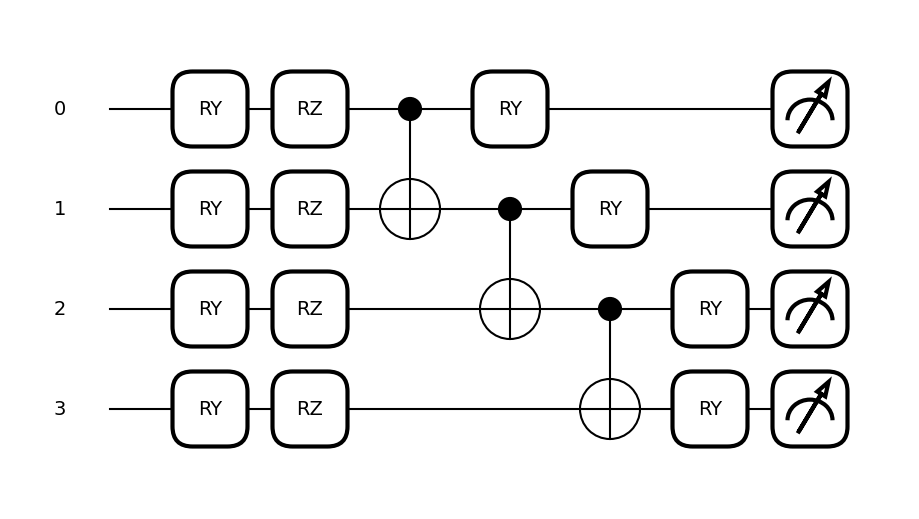

In [ ]:
qml.draw_mpl(sequence_circuit)(params_seq)

# Secuencias de 2 palabras

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# =============================================================================
# 1. Configuración del dispositivo para 6 qubits (secuencias de 2 palabras)
# =============================================================================
dev_words = qml.device("default.qubit", wires=6, shots=None)

# =============================================================================
# 2. Vocabulario y mapeo de bits a palabras
# =============================================================================
# Cada palabra se codifica con 3 bits.
bit_to_word = {
    "000": "hola",
    "001": "mundo",
    "010": "amigo",
    "011": "casa",
    "100": "perro",
    "101": "gato",
    "110": "sol",
    "111": "luna"
}

def bitstring_to_sequence_2words(bitstring):
    """
    Convierte un bitstring de 6 bits en una secuencia de 2 palabras.
    Se toman los 3 primeros bits para la primera palabra y los 3 últimos para la segunda.
    """
    first = bitstring[:3]
    second = bitstring[3:]
    return bit_to_word[first] + " " + bit_to_word[second]

def all_bitstrings(n):
    """Genera una lista de todos los bitstrings de longitud n en orden lexicográfico."""
    if n == 0:
        return [""]
    else:
        smaller = all_bitstrings(n-1)
        return [s + "0" for s in smaller] + [s + "1" for s in smaller]

# Lista de todos los bitstrings de 6 bits (64 estados)
bitstrings6 = all_bitstrings(6)

# =============================================================================
# 3. Distribución objetivo para las secuencias
# =============================================================================
# Se definen 4 secuencias relevantes; el resto tendrá target 0.
target_seq_probs = {
    "hola mundo": 0.30,
    "amigo casa": 0.20,
    "perro gato": 0.25,
    "sol luna": 0.25
}

# Creamos el vector target de 64 elementos.
target_distribution = np.array(
    [target_seq_probs.get(bitstring_to_sequence_2words(bs), 0.0) for bs in bitstrings6]
)
print("Suma de la distribución objetivo:", np.sum(target_distribution))  # Debe ser 1.0

# =============================================================================
# 4. Definición del circuito cuántico generador usando StronglyEntanglingLayers
# =============================================================================
# Usaremos 6 qubits y 3 capas; la plantilla requiere un parámetro de forma (layers, wires, 3)
num_layers = 3
num_wires = 6
param_shape = (num_layers, num_wires, 3)

@qml.qnode(dev_words)
def word_sequence_circuit(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_wires))
    return qml.probs(wires=range(num_wires))

# =============================================================================
# 5. Definición de la función de costo modificada
# =============================================================================
def cost_fn(params, lam=10.0):
    """
    Calcula el costo combinando:
      - MSE en los estados relevantes (donde target_distribution > 0)
      - Una penalización que fuerza a que la suma de probabilidades en los estados relevantes se acerque a 1.
    """
    output_probs = word_sequence_circuit(params)
    # Seleccionamos los índices de los estados relevantes
    target_indices = target_distribution > 0
    mse_target = np.mean((output_probs[target_indices] - target_distribution[target_indices])**2)
    sum_target = np.sum(output_probs[target_indices])
    penalty = lam * (1 - sum_target)**2
    return mse_target + penalty

# =============================================================================
# 6. Proceso de entrenamiento
# =============================================================================
opt = qml.AdamOptimizer(stepsize=0.005)
np.random.seed(42)
# Inicializamos 54 parámetros (forma param_shape = (3, 6, 3)) en forma de array.
params_words = 0.01 * np.random.randn(*param_shape)

num_epochs = 1500
for epoch in range(num_epochs):
    params_words, current_cost = opt.step_and_cost(lambda p: cost_fn(p, lam=10.0), params_words)
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: Cost = {current_cost:.6f}")

# =============================================================================
# 7. Evaluación final: Mostrar la distribución generada para las secuencias relevantes
# =============================================================================
final_probs = word_sequence_circuit(params_words)
print("\nDistribución generada final para secuencias de 2 palabras (solo las relevantes):")
for bs, prob in zip(bitstrings6, final_probs):
    seq = bitstring_to_sequence_2words(bs)
    if target_seq_probs.get(seq, 0) > 0:
        print(f"Estado {bs} -> Secuencia '{seq}': Generada {prob:.3f} vs Target {target_seq_probs[seq]:.3f}")


Suma de la distribución objetivo: 1.0
Epoch    0: Cost = 10.063750
Epoch  100: Cost = 6.747559
Epoch  200: Cost = 0.970802
Epoch  300: Cost = 0.021113
Epoch  400: Cost = 0.004150
Epoch  500: Cost = 0.001394
Epoch  600: Cost = 0.000627
Epoch  700: Cost = 0.000291
Epoch  800: Cost = 0.000118
Epoch  900: Cost = 0.000048
Epoch 1000: Cost = 0.000024
Epoch 1100: Cost = 0.000016
Epoch 1200: Cost = 0.000012
Epoch 1300: Cost = 0.000010
Epoch 1400: Cost = 0.000009

Distribución generada final para secuencias de 2 palabras (solo las relevantes):
Estado 000001 -> Secuencia 'hola mundo': Generada 0.299 vs Target 0.300
Estado 100101 -> Secuencia 'perro gato': Generada 0.249 vs Target 0.250
Estado 010011 -> Secuencia 'amigo casa': Generada 0.200 vs Target 0.200
Estado 110111 -> Secuencia 'sol luna': Generada 0.250 vs Target 0.250


(<Figure size 400x700 with 1 Axes>, <Axes: >)

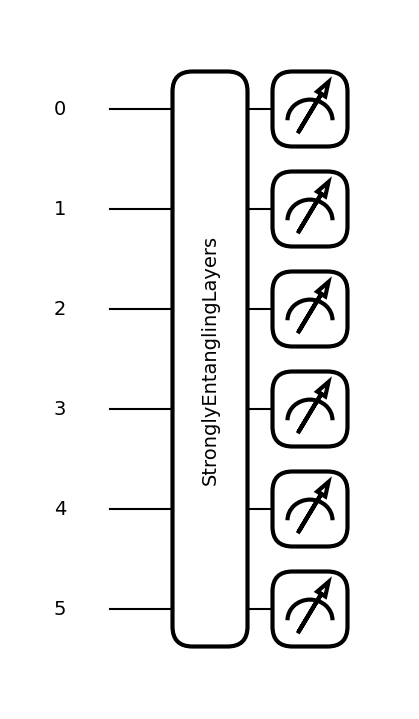

In [ ]:
qml.draw_mpl(word_sequence_circuit)(params_words)

# Secuencias de 3 palabras

In [ ]:
import pennylane as qml
from pennylane import numpy as np

# =============================================================================
# 1. Configuración del dispositivo para 9 qubits (secuencias de 3 palabras)
# =============================================================================
dev_words_3 = qml.device("default.qubit", wires=9, shots=None)

# =============================================================================
# 2. Definición del vocabulario y mapeo de bits a palabras
# =============================================================================
# Cada palabra se codifica con 3 bits (vocabulario de 8 palabras)
bit_to_word = {
    "000": "hola",
    "001": "mundo",
    "010": "amigo",
    "011": "casa",
    "100": "perro",
    "101": "gato",
    "110": "sol",
    "111": "luna"
}

def bitstring_to_sequence_3words(bitstring):
    """
    Convierte un bitstring de 9 bits en una secuencia de 3 palabras.
    Se divide el bitstring en 3 grupos de 3 bits.
    """
    word1 = bitstring[:3]
    word2 = bitstring[3:6]
    word3 = bitstring[6:]
    return bit_to_word[word1] + " " + bit_to_word[word2] + " " + bit_to_word[word3]

def all_bitstrings(n):
    """Genera una lista de todos los bitstrings de longitud n en orden lexicográfico."""
    if n == 0:
        return [""]
    else:
        smaller = all_bitstrings(n-1)
        return [s + "0" for s in smaller] + [s + "1" for s in smaller]

# Lista de todos los bitstrings de 9 bits (512 estados)
bitstrings9 = all_bitstrings(9)

# =============================================================================
# 3. Distribución objetivo para las secuencias
# =============================================================================
# Definimos 4 secuencias relevantes; el resto tendrá target 0.
target_seq_probs = {
    "hola mundo amigo": 0.30,
    "amigo casa perro": 0.25,
    "perro gato sol": 0.20,
    "sol luna hola": 0.25
}

# Creamos el vector de distribución objetivo de 512 elementos.
target_distribution = np.array(
    [target_seq_probs.get(bitstring_to_sequence_3words(bs), 0.0) for bs in bitstrings9]
)
print("Suma de la distribución objetivo:", np.sum(target_distribution))  # Debe dar 1.0

# =============================================================================
# 4. Definición del circuito cuántico generador usando StronglyEntanglingLayers
# =============================================================================
# Usamos 9 qubits y 3 capas. El template requiere parámetros de forma (layers, wires, 3).
num_layers = 3
num_wires = 9
param_shape = (num_layers, num_wires, 3)

@qml.qnode(dev_words_3)
def word_sequence_circuit_3words(params):
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_wires))
    return qml.probs(wires=range(num_wires))

# =============================================================================
# 5. Función de costo basada en MSE + penalización
# =============================================================================
def cost_mse(params, lam=20.0):
    """
    Calcula el costo como:
      - MSE entre la distribución generada y el target (en todos los 512 estados)
      - Una penalización que fuerza a que la suma de la probabilidad en los estados relevantes (target > 0) se acerque a 1.
    """
    output_probs = word_sequence_circuit_3words(params)
    mse = np.mean((output_probs - target_distribution)**2)
    p_total = np.sum(output_probs[target_distribution > 0])
    penalty = lam * (1 - p_total)**2
    return mse + penalty

# =============================================================================
# 6. Función para entrenar una corrida y devolver resultados
# =============================================================================
def train_run(seed, epochs=1500, stepsize=0.005, lam=20.0):
    np.random.seed(seed)
    params = 0.01 * np.random.randn(*param_shape)
    opt = qml.AdamOptimizer(stepsize=stepsize)
    for epoch in range(epochs):
        params, current_cost = opt.step_and_cost(lambda p: cost_mse(p, lam=lam), params)
        # Opcional: imprimir cada 200 épocas
        if epoch % 200 == 0:
            print(f"Seed {seed:2d}, Epoch {epoch:4d}: Cost = {current_cost:.6f}")
    final_probs = word_sequence_circuit_3words(params)
    return params, current_cost, final_probs

# =============================================================================
# 7. Múltiples reinicios (por ejemplo, 5 corridas) y elección del mejor resultado
# =============================================================================
num_restarts = 5
best_cost = float('inf')
best_params = None
best_probs = None
best_seed = None

for seed in range(1, num_restarts+1):
    print("\nEntrenando con seed =", seed)
    params, final_cost, final_probs = train_run(seed, epochs=1500, stepsize=0.005, lam=20.0)
    print(f"Seed {seed}: Final Cost = {final_cost:.6f}")
    if final_cost < best_cost:
        best_cost = final_cost
        best_params = params
        best_probs = final_probs
        best_seed = seed

print("\nMejor corrida obtenida con seed =", best_seed)
print("Costo final:", best_cost)

# =============================================================================
# 8. Evaluación final: Mostrar la distribución generada para las secuencias relevantes
# =============================================================================
print("\nDistribución generada final para secuencias de 3 palabras (solo las relevantes):")
for bs, prob in zip(bitstrings9, best_probs):
    seq = bitstring_to_sequence_3words(bs)
    if target_seq_probs.get(seq, 0) > 0:
        print(f"Estado {bs} -> Secuencia '{seq}': Generada {prob:.3f} vs Target {target_seq_probs[seq]:.3f}")


Suma de la distribución objetivo: 1.0

Entrenando con seed = 1
Seed  1, Epoch    0: Cost = 20.002449
Seed  1, Epoch  200: Cost = 11.725174
Seed  1, Epoch  400: Cost = 6.786943
Seed  1, Epoch  600: Cost = 5.020669
Seed  1, Epoch  800: Cost = 5.000499
Seed  1, Epoch 1000: Cost = 5.000501
Seed  1, Epoch 1200: Cost = 5.000499
Seed  1, Epoch 1400: Cost = 5.000499
Seed 1: Final Cost = 5.000499

Entrenando con seed = 2
Seed  2, Epoch    0: Cost = 20.002448
Seed  2, Epoch  200: Cost = 6.948665
Seed  2, Epoch  400: Cost = 5.002860
Seed  2, Epoch  600: Cost = 5.000430
Seed  2, Epoch  800: Cost = 5.000420
Seed  2, Epoch 1000: Cost = 5.000414
Seed  2, Epoch 1200: Cost = 5.000406
Seed  2, Epoch 1400: Cost = 5.000393
Seed 2: Final Cost = 5.000386

Entrenando con seed = 3
Seed  3, Epoch    0: Cost = 20.002448
Seed  3, Epoch  200: Cost = 0.650780
Seed  3, Epoch  400: Cost = 0.005039
Seed  3, Epoch  600: Cost = 0.000478
Seed  3, Epoch  800: Cost = 0.000064
Seed  3, Epoch 1000: Cost = 0.000013
Seed  3, 

(<Figure size 400x1000 with 1 Axes>, <Axes: >)

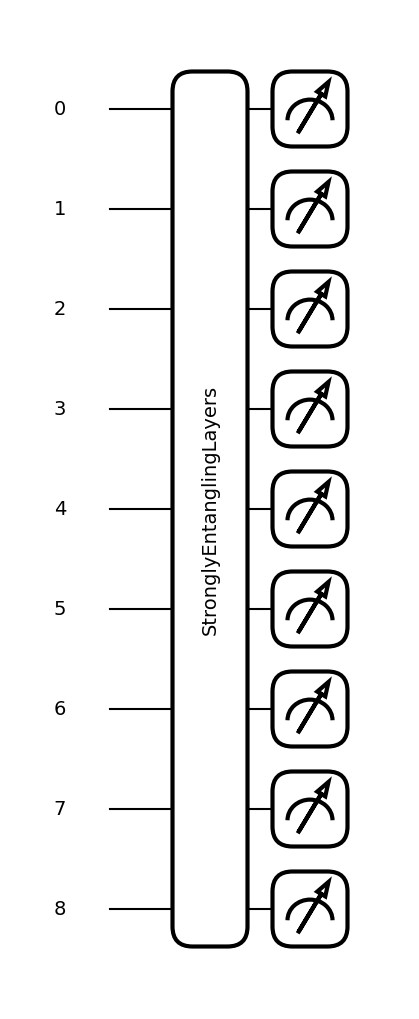

In [ ]:
qml.draw_mpl(word_sequence_circuit_3words)(params_words_3words)